# Compare Gaussian fits across all flights

In [59]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
from beamcals.sites import site
from astropy.modeling.models import AiryDisk2D

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')


freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'

In [60]:
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val,ax='x'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[0,1,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[0,:,0])
    ok = True
    while(ok):
        if ax=='x':
            col = np.where((beam.x_centers_grid[0,:,0] < val+tol) & (beam.x_centers_grid[0,:,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        if ax=='y':
            col = np.where((beam.y_centers_grid[:,0,0] < val+tol) & (beam.y_centers_grid[:,0,0] > val-tol))[0][0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=3
        if tol > 30: ok = False
    return col

def get_slice_anyin(LX,LY,val,ax='x'):
    tol = abs(LX[0,1] - LX[0,0])/1.5
    if ax=='x':
        col = np.where((LX[0,:] < val+tol) & (LX[0,:] > val-tol))[0][0]
    if ax=='y':
        col = np.where((LY[:,0] < val+tol) & (LY[:,0] > val-tol))[0][0]
    return col

def get_slice_xy(xes,yes,zes,val,ax='x'):
    tol = 2
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col

def Gauss_2D_fromgrid(beam,concat,find,chind):
    xes = np.ndarray.flatten(beam.x_centers_grid[:,:,0])
    yes = np.ndarray.flatten(beam.y_centers_grid[:,:,0])
    Gfit = np.zeros(beam.V_LC_operation[:,:,0,0].shape)
    P = [1.0,0.0,concat.G_popt[chind,find,2],0.0,
        concat.G_popt[chind,find,4],concat.G_popt[chind,find,5]]
    #fits = fu.Gauss_2d_LC_func(concat.G_popt[chind,find,:-1],xes,yes)
    fits = fu.Gauss_2d_LC_func(P,xes,yes)
    reshapefits = fits.reshape((beam.x_centers_grid[:,:,0].shape))
    return reshapefits

def get_beam_diff(beam2, beam1,n):
    return beam2[:,:] - n*beam1[:,:]

def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    return stat

In [61]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

['Averaged_2dGauss_and_Airy_Param.npz'
 'FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY619_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625_Corrected_amplitudes.pkl' 'FL

589.84375
618 N [1, 3, 9, 11, 15] [0, 2, 8, 10, 14] 46
1
['/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230910T223223_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230910T223223_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230910T223223_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230910T223223_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230910T223223_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230910T223223_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230910T223223_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230910T223223_concat.pkl', '/hirax/GBO_Analysis_Outputs/flight_pickles/FLY618_20211021T183430Z_ver_20230910T223223_concat.pkl', '/hirax/GBO_Analysis_Outputs/flig

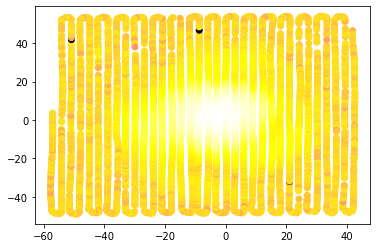

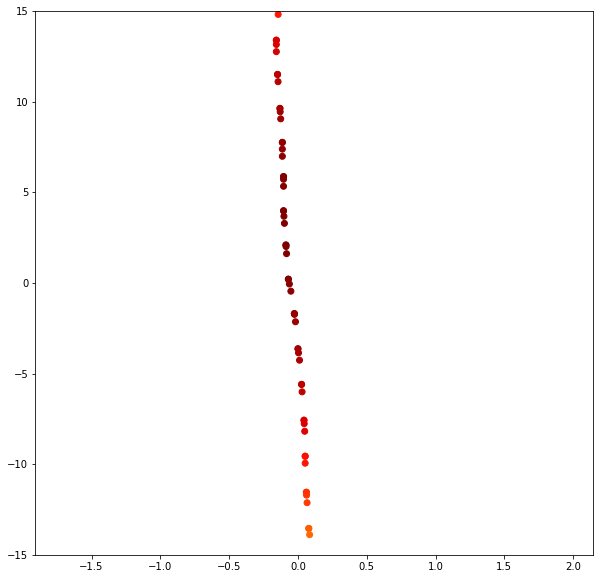

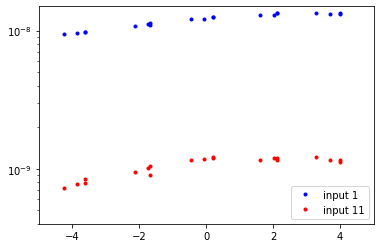

4592 -0.10479770580345615 3.985683084605004 1.340331248165778e-08 1.1494271775596163e-09
4593 -0.10479770580345615 3.985683084605004 1.3144270622686587e-08 1.1278214035453376e-09
4594 -0.10199696109282137 3.6830399190126424 1.3152003215491699e-08 1.1655746507702875e-09
4595 -0.09837028757352703 3.2911484516177194 1.3355097491225919e-08 1.226525676410568e-09
4596 -0.08733144329622178 2.0983122802185785 1.3364346278698697e-08 1.2023423714612526e-09
4597 -0.08733144329622178 2.0983122802185785 1.3358054070827873e-08 1.161480925167582e-09
4598 -0.08655611550039237 2.014531878898808 1.3008950248597159e-08 1.1933210131886242e-09
4599 -0.08289316691436502 1.6187208371667479 1.3076041862641497e-08 1.1578420579651773e-09
4600 -0.06986517216452626 0.21094144809998516 1.2485863088251469e-08 1.196050163590428e-09
4601 -0.06986517216452626 0.21094144809998516 1.2546359255491452e-08 1.2153816456032035e-09
4602 -0.06244865153439309 -0.05619647363811081 1.2212265760470659e-08 1.1760363939772013e-09
46

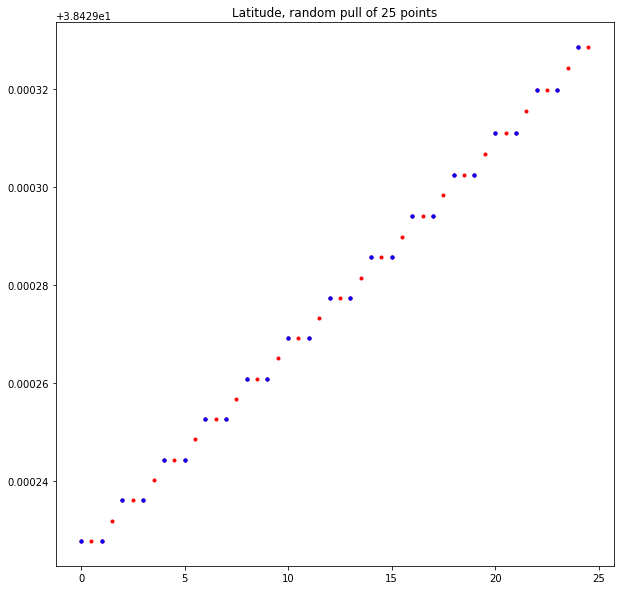

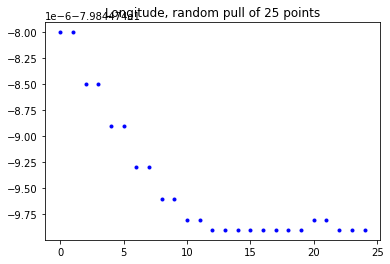

13 7
[38.4292278 38.4292278 38.4292361 38.4292361 38.4292444 38.4292444
 38.4292527 38.4292527 38.4292609 38.4292609 38.4292692 38.4292692
 38.4292774 38.4292774 38.4292857 38.4292857 38.4292941 38.4292941
 38.4293025 38.4293025 38.4293111 38.4293111 38.4293198 38.4293198
 38.4293286]
[ 0  2  4  6  8 10 12 14 16 18 20 22 24]


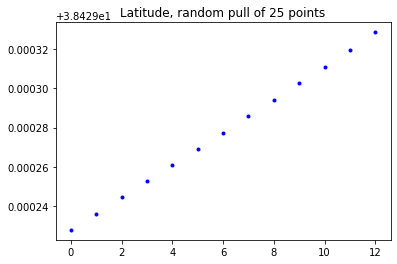

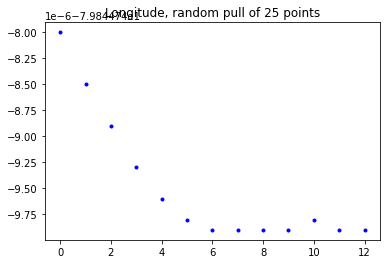

In [62]:
##############################################################################
##############################################################################
###### Check and maybe remove repeated indices   #########
##############################################################################
##############################################################################

# Now let's try to look at a slice through the beam with a fit, pick a 'good' frequency first
find = good_freqs[0]
print(freqs[find])

fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)

# Choose which dish here
chind = pols[0]
print(chind)

concytest=[glob.glob(pckldir+'*'+fly+'*')[0] for x in flights]
print(concytest)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest1=pickle.load(pfile)
t_cut=concattest1.inds_on 

print(concattest1.G_popt[chind,find,:])
# plot scatter plot and beam map
plt.scatter(concattest1.drone_xyz_per_dish_interp[chind,t_cut,0],
                     concattest1.drone_xyz_per_dish_interp[chind,t_cut,1],
                     c=concattest1.V_bgsub[t_cut,find,chind],cmap=cm.gnuplot2,norm=LogNorm())
plt.show()

x = concattest1.drone_xyz_per_dish_interp[chind,t_cut,0]
y = concattest1.drone_xyz_per_dish_interp[chind,t_cut,1]
z = concattest1.V_bgsub[t_cut,find,chind]


pp = get_slice_xy(x,y,z,0.0,'x')

plt.figure(1,figsize=(10,10))
plt.scatter(x[pp],y[pp],c=z[pp],cmap=cm.jet,norm=LogNorm())
plt.ylim(-15,15)
#plt.xlim(5.35,5.48)
plt.show()

chind = 1
x = concattest1.drone_xyz_LC_interp[t_cut,0]
y = concattest1.drone_xyz_LC_interp[t_cut,1]
z = concattest1.V_bgsub[t_cut,find,chind]

pp = get_slice_xy(x,y,z,0.0,'x')

plt.semilogy(y[pp],z[pp],'b.',label='input 1')

chind = 11
zn = concattest1.V_bgsub[t_cut,find,chind]

plt.semilogy(y[pp],zn[pp],'r.',label='input 11')
plt.xlim(-5,5)
plt.ylim(4E-10,1.5E-8)
plt.legend()
plt.show()

for i in pp:
    if y[i] > -5 and y[i] < 5:
        print(i, x[i], y[i], z[i], zn[i])

        
import pandas
skip_rows=np.arange(1,500).tolist()
drdatt = '/hirax/all_drone_data/datcon_csv/FLY618.csv'
drone_data = pandas.read_csv(drdatt,skiprows=skip_rows,float_precision='round_trip',low_memory=False)

if "GPS(0):Lat" in drone_data.columns:
    latitude=np.array(drone_data["GPS(0):Lat"])
    print('1')
elif "GPS:Lat" in drone_data.columns:
    latitude=np.array(drone_data["GPS:Lat"])
    print('2')
if "GPS(0):Long" in drone_data.columns:
    longitude=np.array(drone_data["GPS(0):Long"])
    print('3')
elif "GPS:Long" in drone_data.columns:
    longitude=np.array(drone_data["GPS:Long"])  
    print('4')
    
pandas.set_option("display.precision", 16)
print(np.unique(longitude[8975:9000]))
    #print(np.unique(latitude[8975:9000]))
    
t_arr_datetime=np.array(tu.interp_time(drone_data)["UTC"],dtype='object')

# check what interpoloating does

print(t_arr_datetime[8975:9000])

plt.figure(1,figsize=(10,10))
ll = latitude[8975:9000]
tt = np.arange(0,len(ll))
plt.plot(tt,ll,'b.')

nt = np.arange(0,len(ll),0.5)
temp = np.interp(nt,tt,ll)
plt.plot(nt,temp,'r.')

print(len(temp),len(np.unique(temp)))
#drone_xyz_LC_interp[CORR_t_ind_lb:CORR_t_ind_ub,i]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.coords_xyz_LC[:,i])

plt.plot(latitude[8975:9000],'b.')
plt.title('Latitude, random pull of 25 points')
plt.show()

plt.plot(longitude[8975:9000],'b.')
plt.title('Longitude, random pull of 25 points')
plt.show()

print(len(np.unique(latitude[8975:9000])),len(np.unique(longitude[8975:9000])))

# now let's try to remove repeated values:
print(latitude[8975:9000])
nrri = np.array(np.sort(np.unique(latitude[8975:9000],return_index=True)),dtype=int)
nrri = nrri[1,:]
print(nrri)

plt.plot(latitude[8975:9000][nrri],'b.')
plt.title('Latitude, random pull of 25 points')
plt.show()

plt.plot(longitude[8975:9000][nrri],'b.')
plt.title('Longitude, random pull of 25 points')
plt.show()

In [63]:
latt = latitude[8990:9000]
longg = longitude[8990:9000]

print(latt)
print(longg)

[38.4292857 38.4292941 38.4292941 38.4293025 38.4293025 38.4293111
 38.4293111 38.4293198 38.4293198 38.4293286]
[-79.8447499 -79.8447499 -79.8447499 -79.8447499 -79.8447499 -79.8447498
 -79.8447498 -79.8447499 -79.8447499 -79.8447499]


In [64]:
newll = np.concatenate((latt,longg)).reshape((len(latt),2),order='F')
print(newll)
pairs, nrri = np.unique(newll, return_index=True,axis=0)
print(pairs,nrri)



[[ 38.4292857 -79.8447499]
 [ 38.4292941 -79.8447499]
 [ 38.4292941 -79.8447499]
 [ 38.4293025 -79.8447499]
 [ 38.4293025 -79.8447499]
 [ 38.4293111 -79.8447498]
 [ 38.4293111 -79.8447498]
 [ 38.4293198 -79.8447499]
 [ 38.4293198 -79.8447499]
 [ 38.4293286 -79.8447499]]
[[ 38.4292857 -79.8447499]
 [ 38.4292941 -79.8447499]
 [ 38.4293025 -79.8447499]
 [ 38.4293111 -79.8447498]
 [ 38.4293198 -79.8447499]
 [ 38.4293286 -79.8447499]] [0 1 3 5 7 9]


In [65]:
newll = np.concatenate((latitude,longitude)).reshape((len(latitude),2),order='F')
nrri = np.sort(np.unique(newll, return_index=True,axis=0)[1])
print(len(latitude),len(nrri))

16406 6128


(32812,) (16406,) (16406,)
38.4298116 38.4298116 -79.8443978
(16406, 2) [ 38.4298116 -79.8443978]


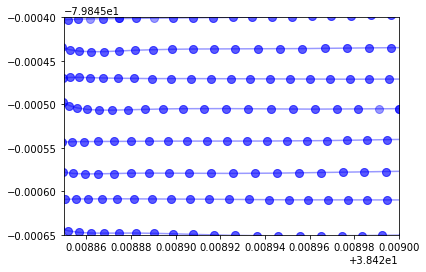

In [66]:
t1 = np.concatenate((latitude,longitude))
print(t1.shape,latitude.shape, longitude.shape)
print(t1[0],latitude[0],longitude[0])

t2 = t1.reshape(len(latitude),2, order='F')
print(t2.shape, t2[0])

plt.plot(latitude,longitude,color='blue',alpha=0.4,marker='o',ms=8)
#plt.plot(latitude[nrri],longitude[nrri],color='red',alpha=0.2,marker='s',ms=10)
plt.xlim(38.42885, 38.4290)
plt.ylim(-79.84565,-79.8454)
plt.show()

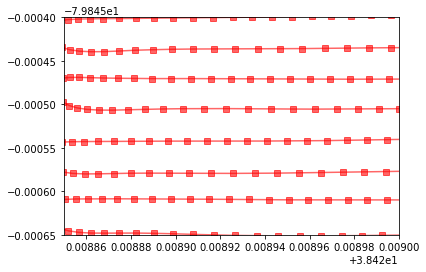

In [67]:

plt.plot(latitude[nrri],longitude[nrri],color='red',alpha=0.6,marker='s')
plt.xlim(38.42885, 38.4290)
plt.ylim(-79.84565,-79.8454)
plt.show()

In [68]:
print(t_arr_datetime[0],t_arr_datetime[-1])

print(t_arr_datetime[-1]-t_arr_datetime[0])

27.5*60 / len(nrri) # sample rate in seconds, checks out

2021-10-21 18:25:07.095000+00:00 2021-10-21 18:52:32.541000+00:00
0 days 00:27:25.446000


0.26925587467362927

In [69]:
class Drone_practice_class:
    def __init__(self,Drone_Directory,FLYTAG,site_class,tlb=0,tub=-1,ignore_rtk=False):
        
        self.FLYTAG=FLYTAG
        self.Drone_Directory=Drone_Directory
        ## Import variables from site-specific site_class object:
        self.name=site_class.name
        self.n_dishes=site_class.n_dishes
        self.n_channels=site_class.n_channels
        self.chmap=site_class.chmap
        self.origin=site_class.origin
        self.prime_origin=pygeodesy.EcefCartesian(latlonh0=self.origin[0],lon0=self.origin[1],height0=self.origin[2])
        self.dish_keystrings=site_class.keystrings
        self.dish_coords=site_class.coords
        self.dish_pointings=site_class.pointings
        self.dish_polarizations=site_class.polarizations
        ## Read Drone RTK Data
        if tlb == 0:
            skip_rows = np.arange(1,500).tolist()
        else: skip_rows = np.arange(1,500+tlb).tolist()
        if tub == -1:
            drone_data=pandas.read_csv(self.Drone_Directory+self.FLYTAG,skiprows=skip_rows,low_memory=False)
        else:
            num_rows = tub - tlb
            drone_data=pandas.read_csv(self.Drone_Directory+self.FLYTAG,skiprows=skip_rows,nrows=num_rows,low_memory=False)
        ## Assign Drone RTK Data to class variables:
        self.ignore_rtk=ignore_rtk
        if "_processed" in self.FLYTAG:
            print("Initializing drone data via processed_csv routine: {}".format(self.FLYTAG))
            print("  --> Skipping rows {} to {} to eliminate NAN values".format(skip_rows[0],skip_rows[-1]))
            ## Load data columns from processed files:
            self.latitude=np.array(drone_data.Lat)
            self.longitude=np.array(drone_data.Lon)
            self.pitch=np.array(drone_data.pitch)
            self.roll=np.array(drone_data.roll)
            self.yaw=np.array(drone_data.yaw)
            self.velocity=np.array(drone_data.vel)
            self.hmsl=np.array(drone_data.hmsl)
            self.altitude=np.array(drone_data.hmsl)[:]-self.origin[2]
            try:
                self.t_arr_timestamp=np.array(drone_data.timestamp)
            except AttributeError:
                self.t_arr_timestamp=np.array(drone_data.datetimestamp)
            self.t_index=np.arange(len(self.t_arr_timestamp))
            self.t_arr_datetime=np.array(drone_data.assign(UTC=pandas.to_datetime(drone_data.UTC)).UTC)
        else:
            print("Initializing drone data via datcon_csv routine: {}".format(self.FLYTAG))
            print("  --> Skipping rows {} to {} to eliminate NAN values".format(skip_rows[0],skip_rows[-1]))
            ## Load data from full datcon files:
            if self.ignore_rtk==False:
                try:
                    ## begin by trying to load RTK data if available:
                    print("  --> Attempting to load position data from RTK")
                    self.latitude=np.array(drone_data["RTKdata:Lat_P"])
                    self.longitude=np.array(drone_data["RTKdata:Lon_P"])
                    self.hmsl=np.array(drone_data["RTKdata:Hmsl_P"])
                    nandtestsum=len(drone_data["RTKdata:Lat_P"][~np.isnan(drone_data["RTKdata:Lat_P"])])
                    print("    --> RTK data contains {}/{} non-nan values".format(nandtestsum,len(drone_data["RTKdata:Lat_P"])))
                    if nandtestsum>0:
                        pass
                    if nandtestsum==0:
                        print("    --> RTK Data not usable for this data file...")
                        print("  --> Loading position data from GPS(0) instead:")
                        if "GPS(0):Lat" in drone_data.columns:
                            self.latitude=np.array(drone_data["GPS(0):Lat"])
                        elif "GPS:Lat" in drone_data.columns:
                            self.latitude=np.array(drone_data["GPS:Lat"])
                        if "GPS(0):Long" in drone_data.columns:
                            self.longitude=np.array(drone_data["GPS(0):Long"])
                        elif "GPS:Long" in drone_data.columns:
                            self.longitude=np.array(drone_data["GPS:Long"])
                        if "GPS(0):heightMSL" in drone_data.columns:
                            self.hmsl=np.array(drone_data["GPS(0):heightMSL"])
                        elif "GPS:heightMSL" in drone_data.columns:
                            self.hmsl=np.array(drone_data["GPS:heightMSL"])
                except KeyError:
                    ## If RTK data is not present, default to GPS(0) data:
                    print("    --> RTK Data not found for this data file...")
                    print("  --> Loading position data from GPS(0) instead:")
                    if "GPS(0):Lat" in drone_data.columns:
                        self.latitude=np.array(drone_data["GPS(0):Lat"])
                    elif "GPS:Lat" in drone_data.columns:
                        self.latitude=np.array(drone_data["GPS:Lat"])
                    if "GPS(0):Long" in drone_data.columns:
                        self.longitude=np.array(drone_data["GPS(0):Long"])
                    elif "GPS:Long" in drone_data.columns:
                        self.longitude=np.array(drone_data["GPS:Long"])
                    if "GPS(0):heightMSL" in drone_data.columns:
                        self.hmsl=np.array(drone_data["GPS(0):heightMSL"])
                    elif "GPS:heightMSL" in drone_data.columns:
                        self.hmsl=np.array(drone_data["GPS:heightMSL"])
            if self.ignore_rtk==True:
                print("  --> RTK Data is being ignored due to input args...")
                print("  --> Loading position data from GPS(0) instead:")
                if "GPS(0):Lat" in drone_data.columns:
                    self.latitude=np.array(drone_data["GPS(0):Lat"])
                elif "GPS:Lat" in drone_data.columns:
                    self.latitude=np.array(drone_data["GPS:Lat"])
                if "GPS(0):Long" in drone_data.columns:
                    self.longitude=np.array(drone_data["GPS(0):Long"])
                elif "GPS:Long" in drone_data.columns:
                    self.longitude=np.array(drone_data["GPS:Long"])
                if "GPS(0):heightMSL" in drone_data.columns:
                    self.hmsl=np.array(drone_data["GPS(0):heightMSL"])
                elif "GPS:heightMSL" in drone_data.columns:
                    self.hmsl=np.array(drone_data["GPS:heightMSL"])

            ## Load columns that don't depend on the RTK data... 
            ## 8/24 patch: New version of datcon changes column headers to include ':C'
            if "IMU_ATTI(0):pitch" in drone_data.columns:
                self.pitch=np.array(drone_data["IMU_ATTI(0):pitch"])
            elif "IMU_ATTI(0):pitch:C" in drone_data.columns:
                self.pitch=np.array(drone_data["IMU_ATTI(0):pitch:C"])
            if "IMU_ATTI(0):roll" in drone_data.columns:
                self.roll=np.array(drone_data["IMU_ATTI(0):roll"])
            elif "IMU_ATTI(0):roll:C" in drone_data.columns:
                self.roll=np.array(drone_data["IMU_ATTI(0):roll:C"])
            if "IMU_ATTI(0):yaw360" in drone_data.columns:
                self.yaw=np.array(drone_data["IMU_ATTI(0):yaw360"])
            if "IMU_ATTI(0):yaw360:C" in drone_data.columns:
                self.yaw=np.array(drone_data["IMU_ATTI(0):yaw360:C"])
            if "IMU_ATTI(0):velComposite" in drone_data.columns:
                self.velocity=np.array(drone_data["IMU_ATTI(0):velComposite"])
            elif "IMU_ATTI(0):velComposite:C" in drone_data.columns:
                self.velocity=np.array(drone_data["IMU_ATTI(0):velComposite:C"])
            self.t_arr_timestamp=np.array(drone_data["GPS:dateTimeStamp"])
            #self.t_index=np.arange(len(self.t_arr_timestamp))
            self.t_arr_datetime=np.array(tu.interp_time(drone_data)["UTC"],dtype='object')
            self.altitude=self.hmsl-self.origin[2]


            #### Remove identical points
            newll = np.concatenate((self.latitude,self.longitude)).reshape((len(self.latitude),2),order='F')
            nrri = np.sort(np.unique(newll, return_index=True,axis=0)[1])
            
            
            print(nrri[0],nrri[-1])
            #print(len(nrri),len(self.latitude))
            ## redefine everything above:
            self.latitude = self.latitude[nrri]
            self.longitude = self.longitude[nrri]
            self.hmsl = self.hmsl[nrri]
            self.pitch = self.pitch[nrri]
            self.roll = self.roll[nrri]
            self.yaw = self.yaw[nrri]
            self.velocity = self.velocity[nrri]
            self.t_arr_timestamp = self.t_arr_timestamp[nrri]
            self.t_index = np.arange(len(self.t_arr_timestamp))
            self.t_arr_datetime = self.t_arr_datetime[nrri]
            self.altitude = self.altitude[nrri]


        ## Define coordinate systems we will eventually want to use:
        print("  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.")
        self.coords_llh=np.NAN*np.ones((self.t_index.shape[0],3))     ## Lat,Lon,hmsl from drone/RTK
        self.coords_xyz_GC=np.NAN*np.ones((self.t_index.shape[0],3))  ## x,y,z in meters in geocentric cartesian
        self.coords_xyz_LC=np.NAN*np.ones((self.t_index.shape[0],3))  ## x,y,z cartesian wrt a chosen origin (x=E,y=N,z=up)
        self.coords_rpt=np.NAN*np.ones((self.t_index.shape[0],3))     ## r,theta,phi wrt a chosen origin
        ## Populate and calculate these coordinate systems:
        for i in self.t_index[np.where(np.isnan(self.latitude)==False)]:
            try:
                ## Create LatLon point for each recorded drone position:
                p_t=pygeodesy.ellipsoidalNvector.LatLon(self.latitude[i],lon=self.longitude[i],height=self.hmsl[i])
            except:
                print("    --> RangeError for index{}".format(i))
            ## Assign llh, xyz, xyz_prime, rpt_prime coordinates, pointwise:
            self.coords_llh[i]=p_t.to3llh()
            self.coords_xyz_GC[i]=p_t.to3xyz()
            self.coords_xyz_LC[i]=self.prime_origin.forward(p_t).toVector()
            r_prime=np.sqrt(self.coords_xyz_LC[i,0]**2.0+self.coords_xyz_LC[i,1]**2.0+self.coords_xyz_LC[i,2]**2.0)
            phi_prime=np.arctan2(self.coords_xyz_LC[i,1],self.coords_xyz_LC[i,0])
            if phi_prime<0:
                phi_prime=phi_prime+(2.0*np.pi)
            theta_prime=np.arccos(self.coords_xyz_LC[i,2]/r_prime)
            self.coords_rpt[i]=[r_prime,phi_prime,theta_prime]
        print("  --> generating dish and receiver line of sight coordinates.")
        ## Calculate per-dish polar coordinates for drone/receiver in each other's beams as fxn of time:
        self.xyz_per_dish=np.zeros((len(self.dish_keystrings),len(self.t_index),3)) # drone posn wrt receiver
        self.rpt_r_per_dish=np.zeros((len(self.dish_keystrings),len(self.t_index),3)) # drone posn wrt receiver
        self.rpt_t_per_dish=np.zeros((len(self.dish_keystrings),len(self.t_index),3)) # receiver posn wrt drone
        for i in range(len(self.dish_keystrings)):
            ## Receiver RPT after TRANS and ROT: (from receiver N to Drone in Receiver Cartesian "RC" coords)
            drone_xyz_RC=self.coords_xyz_LC-self.dish_coords[i] # translate LC to receiver i position
            self.xyz_per_dish[i,:,:]=drone_xyz_RC
            ## Rotate coord system by dish pointing with rotation matrix (constant in t):
            rec_pointing_rot=gu.rot_mat(np.array([gu.xyz_to_rpt(self.dish_pointings[i])[2],0.0,gu.xyz_to_rpt(self.dish_pointings[i])[1]]))
            ## Populate receiver position wrt drone:
            self.rpt_r_per_dish[i,:,:]=np.array([gu.xyz_to_rpt(rec_pointing_rot@drone_xyz_RC[k]) for k in range(len(self.coords_xyz_LC))])
            ## Transmitter RPT after TRANS and ROT: (from Drone to receiver N in Drone coords)
            rec_xyz_LC=-1.0*(self.coords_xyz_LC)+self.dish_coords[i] # in LC relative to drone, without rotation (yet)
            ## Rotate coord system by drone pointing with rotation matrix (varies with yaw,pitch,roll as fxns of t):
            ypr=np.ndarray((len(self.t_index),3))
            ypr[:,0]=self.yaw
            ypr[:,1]=self.pitch
            ypr[:,2]=self.roll
            self.rpt_t_per_dish[i,:,:]=np.array([gu.xyz_to_rpt(gu.rot_mat(ypr[m,:])@(gu.rot_mat(np.array([90.0,0.0,180.0]))@rec_xyz_LC[m])) for m in range(len(self.coords_xyz_LC))])


In [70]:
fly = '618'
dronedir='/hirax/all_drone_data/datcon_csv/'
documents['flight_info']['flights'][fi]
tub = documents["flight_info"]["tubs"][fi]
tlb = documents["flight_info"]["tlbs"][fi]

dronetest0825=Drone_practice_class(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=tlb,tub=tub)

plt.plot(dronetest0825.t_arr_datetime,dronetest0825.latitude,'b.')
plt.title('Latitude')
#plt.xlim(1000,1025)
plt.show()

plt.plot(dronetest0825.t_arr_datetime,dronetest0825.longitude,'b.')
plt.title('Longitude')
#plt.xlim(1000,1025)
plt.show()

print(dronetest0825.latitude[1000:1025])

#plt.plot(dronetest0825.latitude[4000:4025],'b.')
#plt.show()

#plt.plot(dronetest0825.coords_xyz_LC[4000:4025,1],'b.')
#plt.show()

# drone flies NS or EW (along longitude or latitude), so one won't change much and that's ok
# the other will have a few repeated indices, and that's bad, let's not keep those

nrri_lat = np.array(np.sort(np.unique(dronetest0825.latitude,return_index=True)),dtype=int)[1,:]
nrri_lon = np.array(np.sort(np.unique(dronetest0825.longitude,return_index=True)),dtype=int)[1,:]
print(len(nrri_lat),len(nrri_lon))
if len(nrri_lat) >= len(nrri_lon): 
    nrri = nrri_lat
    print('used latitude')
else:
    nrri = nrri_lon
    print('used longitude')
print(len(nrri),nrri)

plt.plot(nrri,'b.')

plt.plot(np.arange(0,len(nrri)),dronetest0825.latitude[nrri],'b.')
plt.title('Latitude')
plt.xlim(1000,1025)
plt.show()

plt.plot(np.arange(0,len(nrri)),dronetest0825.longitude[nrri],'b.')
plt.title('Longitude')
plt.xlim(1000,1025)
plt.show()

print(dronetest0825.latitude[nrri][1000:1025])

NameError: name 'pygeodesy' is not defined

In [ ]:
plt.plot(dronetest0825.t_arr_datetime,'b.')
plt.title('Latitude')
#plt.xlim(1000,1025)
plt.show()


In [ ]:
print(dronetest0825.t_arr_datetime[0], dronetest0825.t_arr_datetime[-1])